# Matrix Factorisation using drug similarity matrix 
Drug similarity matrix found using morgan fingerprint

In [ ]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from tdc.multi_pred import DTI
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import logging
from rdkit import Chem

# load in the three datasets
data_Kd = DTI(name = 'BindingDB_Kd')
data_Kd.convert_to_log(form = 'binding')

# data_ic50 = DTI(name = 'BindingDB_IC50')
# data_ic50.convert_to_log(form = 'binding')

# data_Ki = DTI(name = 'BindingDB_Ki')
# data_Ki.convert_to_log(form = 'binding')

In [2]:
def data_split(data):
    # split data and get ID dicts
    split = data.get_split(seed = 42,  frac = [0.6, 0.05, 0.35])
    train = split['train']
    test = split['test']

    train = train[['Drug_ID', 'Drug', 'Target', 'Y']].dropna()
    train = train.reset_index(drop=True)

    ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug_ID']))))
    ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))
    Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
    Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())
    
    return train, test, Drug_to_ID, Target_to_ID

def data_loader(data, drug_dict, target_dict):
    # load data into correct format
    data["Target_ID2"] = data["Target"].apply(lambda x:target_dict.get(x))
    data["Drug_ID2"] = data["Drug_ID"].apply(lambda x:drug_dict.get(x))
    data = data.dropna()

    drug_ID = data["Drug_ID2"].to_numpy()
    target_ID = data["Target_ID2"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label

class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_= train
        self.label_= label
    def __len__(self):
    #return size of dataset
        return len(self.feature_)
    def __getitem__(self, idx):
        return  torch.tensor(self.feature_[idx], dtype=torch.long),torch.tensor(self.label_[idx], dtype=torch.float)
    
    
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors, drug_sim_mat):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
        # NEW WEIGHTS FOR THE SIMILARITY MATRIX
        self.drug_sim = drug_sim_mat
        self.user_sim = torch.nn.Embedding(n_users, 1)
#         self.item_sim = torch.nn.Embedding(n_items, 1)
        torch.nn.init.xavier_uniform_(self.user_sim.weight)
#         torch.nn.init.xavier_uniform_(self.item_sim.weight)

        
    def forward(self, user, item):
        user_len = len(user)
#         item_len = len(item)
        
        AAT_list = [torch.dot(self.user_factors(user)[i,:], self.user_factors(user)[i,:]) for i in range(self.user_factors(user).shape[0])]
        AAT = torch.tensor(AAT_list)
        
#         BBT_list = [torch.dot(self.item_factors(item)[i,:], self.item_factors(item)[i,:]) for i in range(self.item_factors(item).shape[0])]
#         BBT = torch.tensor(BBT_list)
        
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        
        # Sd = A*AT
        pred += ((self.drug_sim[user][:,0] * self.user_sim(user).double().reshape(user_len)) - AAT).reshape(user_len,1)
        # St = B*BT
#         pred += ((sim_item[item][:,0] * self.item_sim(item).double().reshape(item_len)) - BBT).reshape(item_len,1)
        
        return pred.squeeze()

In [6]:
def train_model(train_loader, test_loader, model, num_epochs=100):
#     dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # need to change dtype to float to reduce resources required
    # maybe just one csim_drug.to(dev)
    dev = torch.device("cpu")
    loss_func = torch.nn.MSELoss()
    
    model.to(dev)
    
    train_losses = []
    test_losses = []
    for epoch in range(0,num_epochs):
        count = 0
        cum_loss = 0.
        for i, (train_batch, label_batch) in enumerate(train_loader):
            count = 1 + i
            # Predict and calculate loss for user factor and bias
            #### WEIGHTS FOR USER SIMILARITY MATRIX ADDED INTO OPTIMISER HERE
            optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight,
                                         model.user_sim.weight], lr=0.1, weight_decay=1e-3)
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev)).float()    
            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()

            # predict and calculate loss for item factor and bias
            #### WEIGHTS FOR ITEM SIMILARITY MATRIX ADDED INTO OPTIMISER HERE
            optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.1, weight_decay=1e-3)             
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            loss_item = loss.item()
            cum_loss += loss_item


            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()
        train_loss = cum_loss/count
        train_losses.append(train_loss)

        cum_loss =0.
        count = 0
        for i, (test_batch, label_batch) in enumerate(test_loader):
            count = 1 + i
            with torch.no_grad():
                prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
                loss = loss_func(prediction, label_batch.to(dev))
                cum_loss += loss.item()

        test_loss = cum_loss/count
        test_losses.append(test_loss)
        if epoch % 1 == 0:
            print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
    return train_losses, test_losses

In [4]:
def full_model(data, csim_drug, img_name, n_factors=100, bs=100, num_epochs=100):
    train, test, drug_dict, target_dict = data_split(data)
    x_train, y_train = data_loader(train, drug_dict, target_dict)
    x_test, y_test = data_loader(test, drug_dict, target_dict)

    train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)
    
    model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors, csim_drug)

    train_losses, test_losses = train_model(train_dataloader, test_dataloader, model, num_epochs)

    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, test_losses, label='test')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.legend()
    plt.title(img_name)
#     plt.savefig(img_name)
    plt.show()

# Kd dataset

In [8]:
Kd_drug_sim_np = np.loadtxt('../sim_matrix/drug_sim.txt', delimiter=',')
Kd_drug_sim = torch.from_numpy(Kd_drug_sim_np)

epoch:  0  avg training loss:  19.677809991654318  avg test loss:  8.198683418546404
epoch:  1  avg training loss:  10.001030399541186  avg test loss:  5.355859092303684
epoch:  2  avg training loss:  7.862868280927087  avg test loss:  4.430556651524135
epoch:  3  avg training loss:  6.7705337568453166  avg test loss:  3.907692502226148
epoch:  4  avg training loss:  6.038821390479993  avg test loss:  3.5510046439511433
epoch:  5  avg training loss:  5.498122364852079  avg test loss:  3.279595193692616
epoch:  6  avg training loss:  5.066586152003829  avg test loss:  3.0545796377318246
epoch:  7  avg training loss:  4.703981729070092  avg test loss:  2.861006839786257
epoch:  8  avg training loss:  4.394102911280978  avg test loss:  2.688879862001964
epoch:  9  avg training loss:  4.119605742822028  avg test loss:  2.536691336120878
epoch:  10  avg training loss:  3.880750956429038  avg test loss:  2.408498695066997
epoch:  11  avg training loss:  3.6799751504970963  avg test loss:  2.

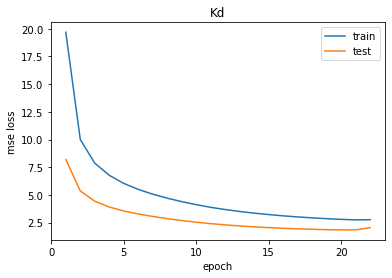

In [7]:
full_model(data_Kd, Kd_drug_sim, 'Kd', n_factors=20, bs=100, num_epochs=100)